<a href="https://colab.research.google.com/github/Abhisikta11/Emotion_Detection3/blob/main/3Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Uploading Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unzipping Dataset**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/3Emotion_Detection"

In [ ]:
%cd /content/drive/MyDrive/3Emotion_Detection

/content/drive/MyDrive/3Emotion_Detection


In [ ]:
pwd

'/content/drive/MyDrive/3Emotion_Detection'

In [ ]:
!kaggle datasets download -d abhisiktanayak/nationality-detection

Dataset URL: https://www.kaggle.com/datasets/abhisiktanayak/nationality-detection
License(s): unknown
nationality-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

'IndiaAmericaAfrica Peoples Dataset'   kaggle.json   model.weights.h5   nationality-detection.zip


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  nationality-detection.zip
replace IndiaAmericaAfrica Peoples Dataset/test/African/10_0_1_20170116225209209.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog, Label, Button

print("Tensorflow version", tf.__version__)
dataset_path = '/content/drive/MyDrive/3Emotion_Detection/IndiaAmericaAfrica Peoples Dataset'

Tensorflow version 2.15.0


**Preparing Dataset**

In [ ]:
img_size = 48
batch_size = 128
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest')

datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory("/content/drive/MyDrive/3Emotion_Detection/IndiaAmericaAfrica Peoples Dataset/train",
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory("/content/drive/MyDrive/3Emotion_Detection/IndiaAmericaAfrica Peoples Dataset/test",
                                                              target_size=(img_size, img_size),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)


Found 14882 images belonging to 3 classes.
Found 3719 images belonging to 3 classes.


**Defining Model**

In [ ]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

def model_fer(input_shape, num_classes):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3, 3))
    conv_2 = Convolution(conv_1, 128, (5, 5))
    conv_3 = Convolution(conv_2, 256, (3, 3))
    conv_4 = Convolution(conv_3, 512, (3, 3))

    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 512)
    output = Dense(num_classes, activation="softmax")(dense_2)

    model = Model(inputs=[inputs], outputs=[output])
    opt = Adam(learning_rate=0.005)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

num_classes = 3
model = model_fer((48, 48, 3), num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

**Initializing the Model**

In [ ]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stop]

**Model Training**

In [ ]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks)

Epoch 1/10
116/116 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.5727 
Epoch 1: saving model to model.weights.h5
116/116 [==============================] - 2950s 23s/step - loss: 1.0079 - accuracy: 0.5727 - val_loss: 1.3723 - val_accuracy: 0.5418 - lr: 0.0050
Epoch 2/10
116/116 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.6444
Epoch 2: saving model to model.weights.h5
116/116 [==============================] - 640s 5s/step - loss: 0.8252 - accuracy: 0.6444 - val_loss: 1.4493 - val_accuracy: 0.5423 - lr: 0.0050
Epoch 3/10
116/116 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.6802
Epoch 3: saving model to model.weights.h5
116/116 [==============================] - 635s 5s/step - loss: 0.7453 - accuracy: 0.6802 - val_loss: 0.7355 - val_accuracy: 0.7029 - lr: 0.0050
Epoch 4/10
116/116 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7283
Epoch 4: saving model to model.weights.h5
116/116 [=

**Evaluating the Model**

In [ ]:
model.evaluate(validation_generator)

30/30 [==============================] - 56s 2s/step - loss: 0.4676 - accuracy: 0.8190


[0.4675616919994354, 0.8190373778343201]

**Plotting**

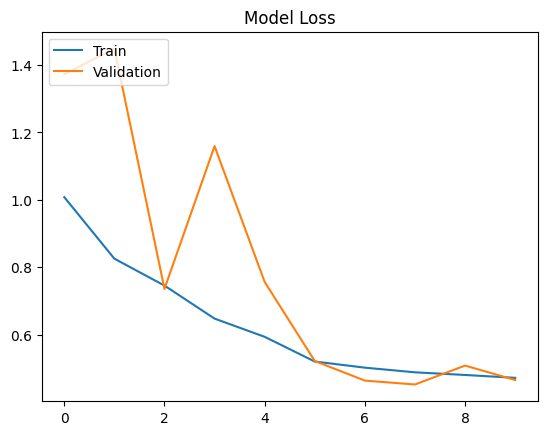

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

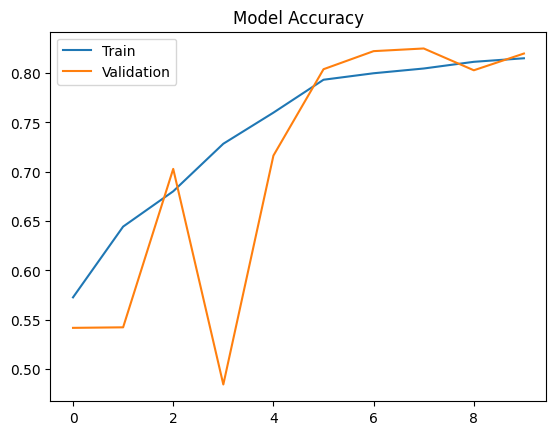

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Saving the Model**

In [ ]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")

**Loading Model**

In [ ]:
!pip install tensorflow
from tensorflow.keras.models import model_from_json

def load_model(json_file, weights_file):
    with open(json_file, "r") as file:
        loaded_model_json = file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(weights_file)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

json_file = "model_a.json"
weights_file = "model.weights.h5"
model = load_model(json_file, weights_file)

# GUI
root = tk.Tk()
root.title("Person Attributes Detection")

def predict_attributes(image):
    facec = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray_image, 1.3, 5)
    results = {}
    EMOTIONS_LIST = ["Happy", "Sad", "Neutral"]
    for (x, y, w, h) in faces:
        roi = image[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype('float') / 255.0
        roi = np.expand_dims(roi, axis=0)
        predictions = model.predict(roi)
        nationality = np.argmax(predictions[0])
        emotion = EMOTIONS_LIST[np.argmax(predictions[1])]
        age = np.argmax(predictions[2])
        dress_color = np.argmax(predictions[3])

        if nationality == 0:
            if 10 <= age <= 60:
                results["Indian"] = {"Age": age, "Dress Color": dress_color, "Emotion": emotion}
        elif nationality == 1:
            if 10 <= age <= 60:
                results["United States"] = {"Age": age, "Emotion": emotion}
        elif nationality == 2:
            results["African"] = {"Dress Color": dress_color, "Emotion": emotion}
        else:
            results["Other"] = {"Emotion": emotion}
    return results

def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = cv2.imread(file_path)
        attributes = predict_attributes(image)
        display_results(file_path, attributes)

def display_results(image_path, attributes):
    img = Image.open(image_path)
    img = img.resize((250, 250), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)

    panel = Label(root, image=img)
    panel.image = img
    panel.pack(side="top", padx=10, pady=10)

    result_text = ""
    for nationality, details in attributes.items():
        result_text += f"Nationality: {nationality}\n"
        for attr, value in details.items():
            result_text += f"{attr}: {value}\n"

    result_label.config(text=result_text)

open_button = Button(root, text="Open Image", command=open_image)
open_button.pack(side="top", padx=10, pady=10)

result_label = Label(root, text="")
result_label.pack(side="top", padx=10, pady=10)

root.mainloop()

TclError: no display name and no $DISPLAY environment variable